# 🛫 Aircraft Threat Detection Using Computer Vision
### *Applied Computer Vision for AI (AAI-521-01) — University of San Diego, Fall 2025*

**Team Members:**  
- Andrew Blumhardt  
- Marwah Faraj  
- Patrick Woo-Sam  

---

### **Project Overview**

This project explores the use of **computer vision and deep learning** to identify and classify aircraft in static images and video feeds.  
Our objective is to detect aircraft, determine their type, and assess potential threat levels by distinguishing between **civilian and military models**.  

The team integrates modern techniques in **image preprocessing, feature extraction, transfer learning, and object detection** to develop a model capable of performing real-time aircraft recognition. This work demonstrates practical applications of visual AI in **aerospace monitoring, defense analysis, and early warning systems**, aligning with the principles of applied computer vision.

🧭 Team Setup Instructions

The datasets for this project are already prepared and stored in the shared Google Drive folder.
Team members only need to mount Drive to access them — no downloads or uploads are required.

Shared Drive Folder: AAI521_TeamProject

Steps to Prepare Your Environment

Open the link above and join the shared Drive folder as an Editor. https://drive.google.com/drive/folders/1psx8Iw6uC7uy6IKipU8PrK_1J4EOP7cC?usp=sharing

Verify you can see the following folders: AAI521_TeamProject/data/raw/

Mount Google Drive when prompted in Colab.

Run the setup cell below to verify your environment and folder structure.

## Import Core Libraries

In [1]:
!pip install ultralytics -q

In [2]:
import os
import random
import numpy as np
import pandas as pd
import cv2
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from IPython.display import display
from PIL import Image
from ultralytics import YOLO

## Download Datasets

In [3]:
fgvc_aircraft_path = kagglehub.dataset_download(
    "seryouxblaster764/fgvc-aircraft")
print("Path to fgvc-aircraft dataset files:",
      fgvc_aircraft_path)

100%|██████████| 2.57G/2.57G [02:00<00:00, 22.8MB/s]

Extracting files...


Path to fgvc-aircraft dataset files: /root/.cache/kagglehub/datasets/seryouxblaster764/fgvc-aircraft/versions/2


In [4]:
militaryaircraftdetectiondataset_path = kagglehub.dataset_download(
    "a2015003713/militaryaircraftdetectiondataset")
print("Path to militaryaircraftdetection dataset files:",
      militaryaircraftdetectiondataset_path)

Using Colab cache for faster access to the 'militaryaircraftdetectiondataset' dataset.
Path to militaryaircraftdetection dataset files: /kaggle/input/militaryaircraftdetectiondataset


## Detect GPU availability

In [5]:
gpu = tf.config.list_physical_devices("GPU")
if gpu:
    print(f"🚀 GPU available: {gpu[0].name}")
else:
    print("⚠️ No GPU detected. Enable GPU in Colab: Runtime → Change runtime type → GPU")

print("\n✨ Setup complete.")

🚀 GPU available: /physical_device:GPU:0

✨ Setup complete.


## Load FGVC dataset (Commercial aircraft)

In [6]:
# FGVC (Commercial Aircraft) Paths
fgvc_dir = os.path.join(fgvc_aircraft_path, "fgvc-aircraft-2013b/fgvc-aircraft-2013b")
fgvc_data_dir = os.path.join(fgvc_dir, "data")
fgvc_img_dir = os.path.join(fgvc_data_dir, "images")

# Annotation Files (variant labels)
variant_filenames = {
    "train": "images_variant_train.txt",
    "validation": "images_variant_val.txt",
    "test": "images_variant_test.txt"
}

# Manually parse variant labels because they're not in a reliable csv format
commercial_records = []
for split, filename in variant_filenames.items():
    filepath = os.path.join(fgvc_data_dir, filename)
    with open(filepath, 'r') as f:
        for line in f:
            # Split only on the first space to handle labels with spaces
            parts = line.strip().split(' ', 1)
            if len(parts) == 2:
                image_id, label = parts
                # Assuming .jpg extension for FGVC
                image_path = os.path.join(fgvc_img_dir, f"{image_id}.jpg")
                commercial_records.append({
                    "image_id": image_id,
                    "image_path": image_path,
                    "label": label,
                    "category": "Commercial",
                    "split": split
                })

commercial_df = pd.DataFrame(commercial_records)

# Add width, height, xmin, ymin, xmax, and ymax from images_box.txt
commercial_box_path = os.path.join(fgvc_data_dir, "images_box.txt")
commercial_box_df = pd.read_csv(
    commercial_box_path,
    sep=' ',
    header=None,
    names=["image_id", "xmin", "ymin", "xmax", "ymax"],
    dtype={
        "image_id": str,
        "xmin": int,
        "ymin": int,
        "xmax": int,
        "ymax": int
    })

# Create a list to store image dimensions
image_dimensions_list = []
for _, row in commercial_df.iterrows():
    image_id = row["image_id"]
    image_path = row["image_path"]
    with Image.open(image_path) as img:
        width, height = img.size
        image_dimensions_list.append({"image_id": image_id, "width": width, "height": height})

commercial_dimensions_df = pd.DataFrame(image_dimensions_list)

# Merge the image dimensions into commercial_box_df based on 'image_id'
commercial_box_df = commercial_box_df.merge(commercial_dimensions_df, on="image_id", how="left")

# Finally, merge the complete commercial_box_df (now with dimensions) into commercial_df
commercial_df = commercial_df.merge(commercial_box_df, on="image_id", how="left")

# Drop image_id because it wont be used anymore
commercial_df = commercial_df.drop(columns=["image_id"])

print(f"🔢 Commercial aircraft samples loaded: {len(commercial_df)}")
print("🛫 Unique commercial aircraft variants:", commercial_df["label"].nunique())

display(commercial_df.head())

🔢 Commercial aircraft samples loaded: 10000
🛫 Unique commercial aircraft variants: 100


image_path    label    category  \
0  /root/.cache/kagglehub/datasets/seryouxblaster...  707-320  Commercial   
1  /root/.cache/kagglehub/datasets/seryouxblaster...  707-320  Commercial   
2  /root/.cache/kagglehub/datasets/seryouxblaster...  707-320  Commercial   
3  /root/.cache/kagglehub/datasets/seryouxblaster...  707-320  Commercial   
4  /root/.cache/kagglehub/datasets/seryouxblaster...  707-320  Commercial   

   split  xmin  ymin  xmax  ymax  width  height  
0  train     3   144   998   431   1024     695  
1  train    83   155   964   462   1024     699  
2  train     1   129   891   436    913     687  
3  train     8   164   996   435   1000     678  
4  train    29   396  1268   634   1280     911

## Display 6 commercial aircraft images

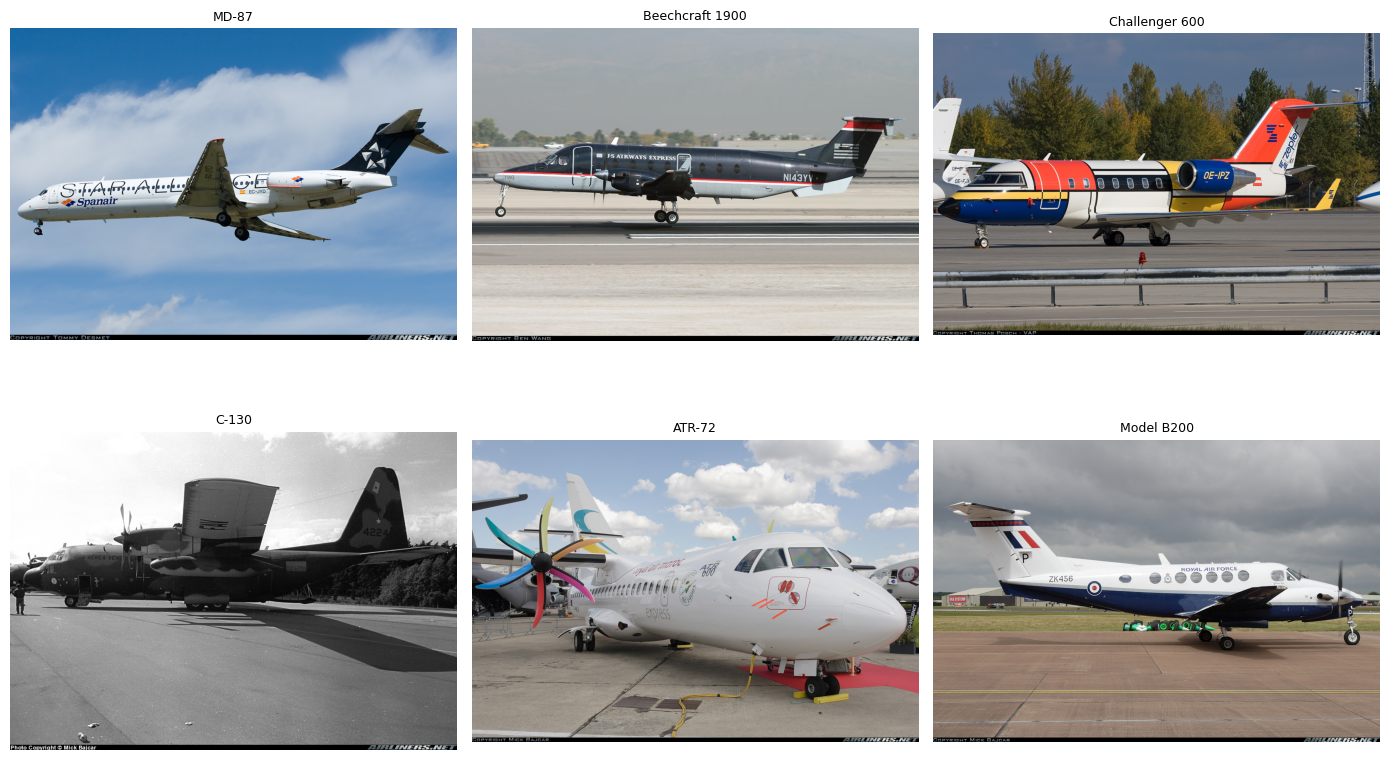

In [7]:
sample_rows = commercial_df.sample(6, random_state=42)

plt.figure(figsize=(14, 9))
for i, (_, row) in enumerate(sample_rows.iterrows(), 1):
    img = plt.imread(row["image_path"])
    plt.subplot(2, 3, i)
    plt.imshow(img)
    plt.title(row["label"], fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()

## Load Military Aircraft Dataset

In [8]:
military_dataset_dir = os.path.join(
    militaryaircraftdetectiondataset_path, "dataset")
military_labels_dir = os.path.join(
    militaryaircraftdetectiondataset_path, "labels_with_split.csv")

military_df = pd.read_csv(military_labels_dir)

# Rename columns to match FGVC for merging later
military_df = military_df.rename(
    columns={
        "filename": "image_path",
        "class": "label",
    })

# build full paths
military_df["image_path"] = military_df["image_path"].apply(
    lambda x: os.path.join(military_dataset_dir, x + '.jpg'))
military_df["category"] = "Military"

print(f"🔢 Military samples loaded (after filtering): {len(military_df)}")
print(f"🛩️ Unique detected military labels: {military_df["label"].nunique()}")
print(f"📋 Example Labels: {sorted(military_df["label"].unique())[:5]}")

display(military_df.head())

🔢 Military samples loaded (after filtering): 39482
🛩️ Unique detected military labels: 96
📋 Example Labels: ['A10', 'A400M', 'AG600', 'AH64', 'AKINCI']


image_path  width  height label  \
0  /kaggle/input/militaryaircraftdetectiondataset...   4928    3264  Mi28   
1  /kaggle/input/militaryaircraftdetectiondataset...   4928    3264  Mi28   
2  /kaggle/input/militaryaircraftdetectiondataset...   4928    3264  Mi28   
3  /kaggle/input/militaryaircraftdetectiondataset...   4928    3264  Mi28   
4  /kaggle/input/militaryaircraftdetectiondataset...   1360    2048  UH60   

   xmin  ymin  xmax  ymax  split  category  
0  1380  1904  1522  2014  train  Military  
1  1809  1625  1958  1759  train  Military  
2  2400  1571  2532  1727  train  Military  
3  3935  1772  4100  1891  train  Military  
4   835   526  1233   741  train  Military

## Display 6 military aircraft images

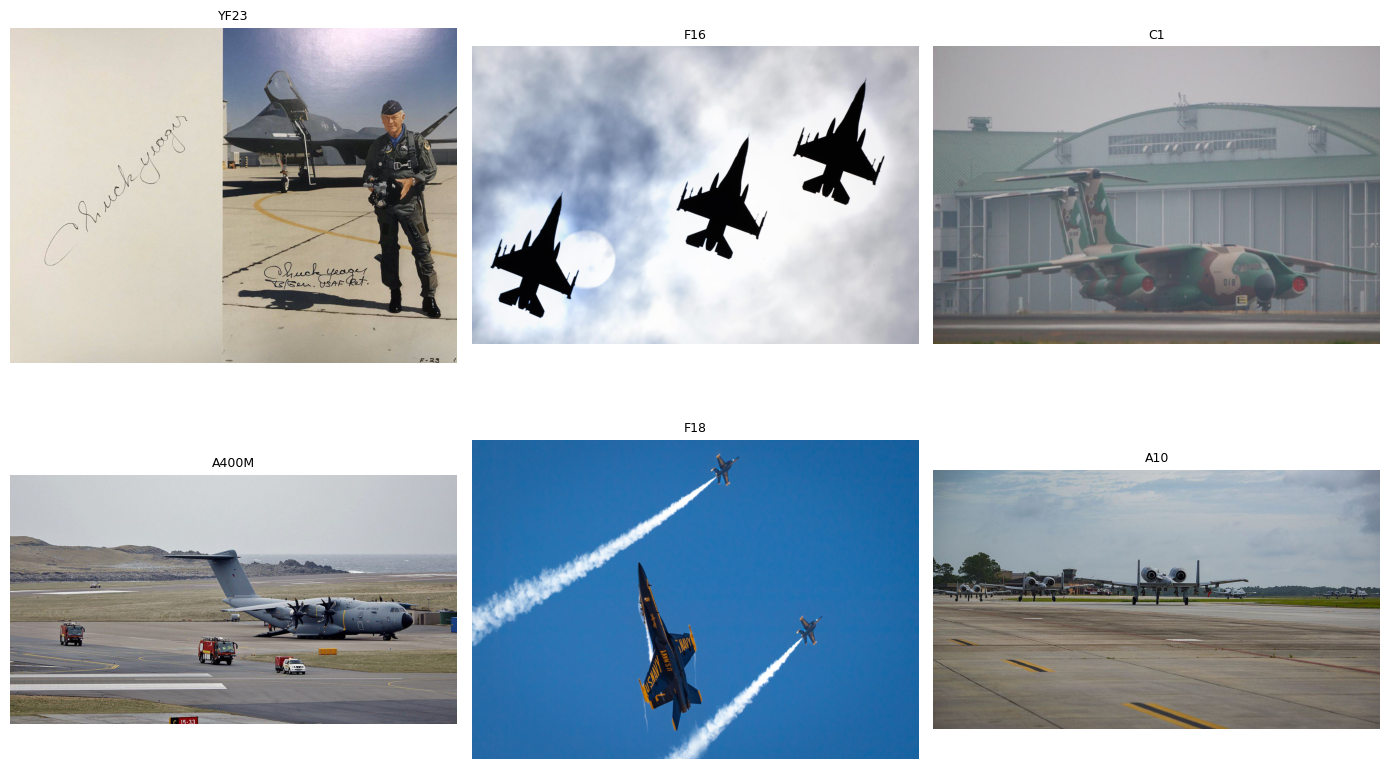

In [9]:
sample_rows = military_df.sample(6, random_state=42)

plt.figure(figsize=(14, 9))
for i, (_, row) in enumerate(sample_rows.iterrows(), 1):
    img = plt.imread(row["image_path"])
    plt.subplot(2, 3, i)
    plt.imshow(img)
    plt.title(row["label"], fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()

## Merge Commercial and Military datasets

In [10]:
# Ensure the expected DataFrames exist
required_cols = {
    "image_path",
    "label",
    "category",
    "width",
    "height",
    "xmin",
    "ymin",
    "xmax",
    "ymax"}

if not required_cols.issubset(commercial_df.columns):
    raise ValueError(f"commercial_df missing required columns: { \
        required_cols.difference(commercial_df.columns)}")

if not required_cols.issubset(military_df.columns):
    raise ValueError(f"military_df missing required columns: { \
        required_cols.difference(military_df.columns)}")

# --- Combine into unified dataset ---
combined_df = pd.concat([commercial_df, military_df], ignore_index=True)

print(f"📦 Total combined samples: {len(combined_df)}")
print("🛫 Commercial samples:", (combined_df["category"] == "Commercial").sum())
print("✈️ Military samples:", (combined_df["category"] == "Military").sum())

# --- Display summary ---
print("\n🟦 Unique Commercial aircraft classes:", commercial_df["label"].nunique())
print("🟥 Unique Military aircraft classes:", military_df["label"].nunique())
print("🟨 Combined unique aircraft types:", combined_df["label"].nunique())

display(combined_df.head())

📦 Total combined samples: 49482
🛫 Commercial samples: 10000
✈️ Military samples: 39482

🟦 Unique Commercial aircraft classes: 100
🟥 Unique Military aircraft classes: 96
🟨 Combined unique aircraft types: 195


image_path    label    category  \
0  /root/.cache/kagglehub/datasets/seryouxblaster...  707-320  Commercial   
1  /root/.cache/kagglehub/datasets/seryouxblaster...  707-320  Commercial   
2  /root/.cache/kagglehub/datasets/seryouxblaster...  707-320  Commercial   
3  /root/.cache/kagglehub/datasets/seryouxblaster...  707-320  Commercial   
4  /root/.cache/kagglehub/datasets/seryouxblaster...  707-320  Commercial   

   split  xmin  ymin  xmax  ymax  width  height  
0  train     3   144   998   431   1024     695  
1  train    83   155   964   462   1024     699  
2  train     1   129   891   436    913     687  
3  train     8   164   996   435   1000     678  
4  train    29   396  1268   634   1280     911

## Check class balance (for reporting)

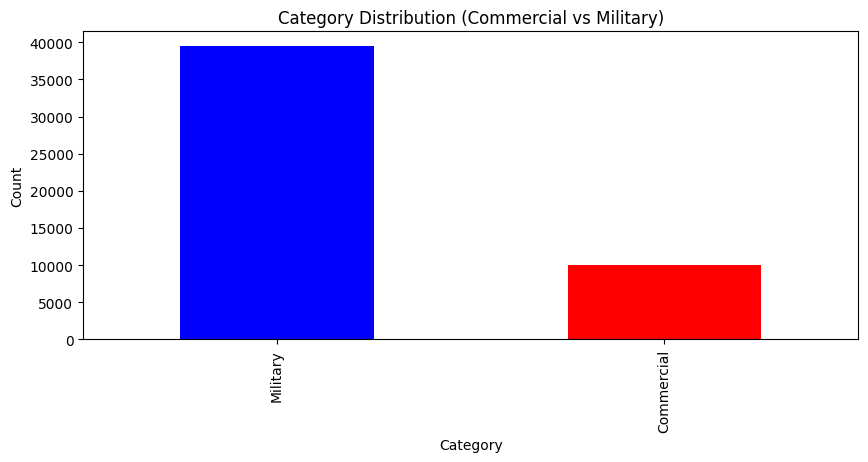

In [11]:
plt.figure(figsize=(10, 4))
combined_df["category"].value_counts().plot(kind="bar", color=["blue", "red"])
plt.title("Category Distribution (Commercial vs Military)")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

## 🖼️ Display 12 random thumbnails from combined dataset

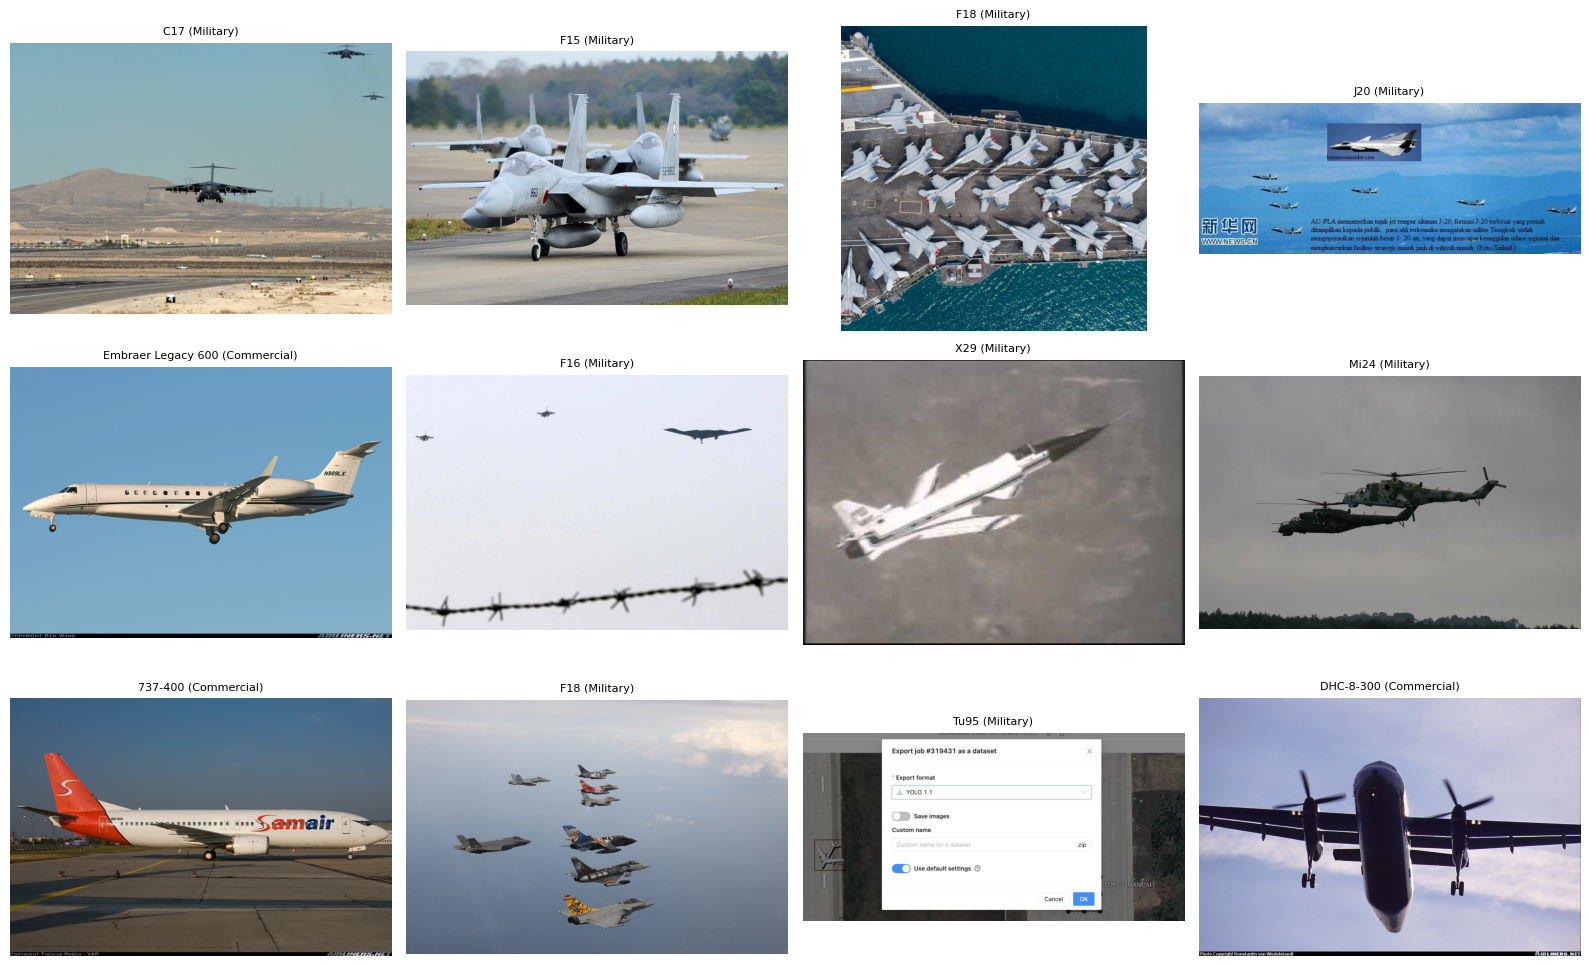

In [12]:
sample_rows = combined_df.sample(12, random_state=42)
plt.figure(figsize=(16, 10))

for i, (_, row) in enumerate(sample_rows.iterrows(), 1):
    img = plt.imread(row["image_path"])
    plt.subplot(3, 4, i)
    plt.imshow(img)
    plt.title(f"{row['label']} ({row['category']})", fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()

## Convert pandas dataframe TensorFlow Dataset for training, validation, and testing

In [13]:
def load_image_and_labels(features):
    image = tf.io.read_file(features['image_path'])
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32) # Normalize to [0, 1]

    # Extract bounding box coordinates and label
    xmin = tf.cast(features['xmin'], tf.float32)
    ymin = tf.cast(features['ymin'], tf.float32)
    xmax = tf.cast(features['xmax'], tf.float32)
    ymax = tf.cast(features['ymax'], tf.float32)
    label = features['label']
    category = features['category']

    # Normalize bounding box coordinates to [0, 1]
    width = tf.cast(features['width'], tf.float32)
    height = tf.cast(features['height'], tf.float32)
    bbox = tf.stack([ymin / height, xmin / width, ymax / height, xmax / width])

    return image, {'bbox': bbox, 'label': label, 'category': category}


# Assign new split values for test, val, train split
combined_shuffled_df = combined_df.copy()
combined_shuffled_df['split'] = np.random.choice(
    ["train", "validation", "test"],
    p=[0.8, 0.1, 0.1],
    size=len(combined_shuffled_df))

# Apply the loading and preprocessing function
train_ds = tf.data.Dataset.from_tensor_slices(
        dict(combined_shuffled_df[combined_shuffled_df['split'] == 'train'])
    ).map(load_image_and_labels)
val_ds = tf.data.Dataset.from_tensor_slices(
        dict(combined_shuffled_df[combined_shuffled_df['split'] == 'validation'])
    ).map(load_image_and_labels)
test_ds = tf.data.Dataset.from_tensor_slices(
        dict(combined_shuffled_df[combined_shuffled_df['split'] == 'test'])
    ).map(load_image_and_labels)


print("Example row from TensorFlow Dataset:")
for image, labels in train_ds.take(1):
    print("Image shape:", image.shape)
    print("Bounding Box:", labels['bbox'])
    print("Label:", labels['label'])
    print("Category:", labels['category'])

Example row from TensorFlow Dataset:
Image shape: (695, 1024, 3)
Bounding Box: tf.Tensor([    0.20719   0.0029297     0.62014     0.97461], shape=(4,), dtype=float32)
Label: tf.Tensor(b'707-320', shape=(), dtype=string)
Category: tf.Tensor(b'Commercial', shape=(), dtype=string)


### 📝 Explanation
This project uses three structured dataset components that support progressively more advanced modeling. The first component, the FGVC Aircraft dataset, provides over ten thousand commercial aircraft images labeled at the variant level, offering clean, high-resolution examples of civilian aircraft. The second component is the Military Aircraft dataset, sourced from Kaggle, which organizes aircraft types into subfolders and provides cropped images of tactical aircraft. These images vary in size and quality, so smaller, unusable samples are filtered out to maintain consistency. After loading and validating each dataset independently, the two sources are merged into a single unified structure that includes the image path, aircraft label, a category field distinguishing Commercial from Military, image size, and box parameters. This combined dataset forms the foundation for a classifier capable of identifying aircraft type while also determining whether a given image represents a potential military threat, directly supporting the goals of the Aircraft Threat Detection project.

In [14]:
# Author: [Name of Contributor]
# Purpose: Clean and standardize images for model input.
# Notes: Resize, normalize, handle corrupt or missing images, and standardize label encoding.
#        Consider creating functions to automate image preprocessing.

# (Write your preprocessing code here)

### 📝 Explanation
Discuss how preprocessing improved data consistency, what transformations were applied, and why certain image dimensions or normalization ranges were chosen.

In [15]:
# Author: [Name of Contributor]
# Purpose: Explore class distribution, visualize samples, identify imbalance or biases.
# Notes: Include plots (class counts, image samples, heatmaps of bounding boxes if applicable).

# (Write your EDA code here)

### 📝 Explanation
Interpret your findings from EDA. Note any class imbalances, visual insights, or anomalies that may affect modeling.

In [16]:
# Author: [Name of Contributor]
# Purpose: Build and evaluate a simple baseline classifier using pretrained CNN (e.g., ResNet50 or MobileNet).
# Notes: Freeze base layers, train only top layers. Establish initial accuracy and confusion matrix.

# (Write your baseline model code here)

### 📝 Explanation
Explain how the baseline model performed and what insights it gave you about model complexity and data quality.

In [17]:
# Author: [Name of Contributor]
# Purpose: Implement an advanced model (YOLOv8, EfficientNet, or similar).
# Notes: Configure hyperparameters, training parameters, and augmentations.
#        Save best weights and evaluate using validation data.

# (Write your model training code here)

### 📝 Explanation
Summarize the model architecture, training observations (loss/accuracy trends), and compare to the baseline.

In [18]:
# Author: [Name of Contributor]
# Purpose: Evaluate model performance using precision, recall, F1-score, confusion matrix, and mAP if applicable.
# Notes: Visualize metrics and sample predictions.

# (Write your evaluation code here)

### 📝 Explanation
Interpret performance results. Highlight key success areas, misclassifications, and potential causes for errors.

In [19]:
# Author: [Name of Contributor]
# Purpose: Create a logic or model extension to classify threat level (civilian vs. military vs. unknown).
# Notes: Combine detection output with label-based classification rules or an additional model.

# (Write your threat classification code here)

### 📝 Explanation
Describe how the threat classification decision process works and evaluate its accuracy or limitations.

In [20]:
# Author: [Name of Contributor]
# Purpose: Demonstrate inference on video or webcam feed using trained model.
# Notes: Process video frame-by-frame and visualize bounding boxes with predictions.

# (Write your real-time detection code here)

### 📝 Explanation
Discuss the real-time demo results and practical considerations like frame rate, detection latency, and visualization clarity.

In [21]:
# Author: [Name of Contributor]
# Purpose: Aggregate model metrics, visualize comparisons, and summarize findings.
# Notes: Present charts comparing baseline vs. final model and provide insights for improvement.

# (Write your results summary code here)

### 📝 Explanation
Reflect on overall results, lessons learned, and areas for future enhancement (data augmentation, larger datasets, etc.).

In [22]:
# Author: [All Team Members]
# Purpose: Document roles, GitHub branch contributions, and collaboration notes.
# Notes: Include references to pull requests, code merges, and review comments.

# (Add documentation of team workflow here)

### 📝 Explanation
Briefly describe how responsibilities were divided and managed throughout the project lifecycle.

In [23]:
# Author: [Name of Contributor]
# Purpose: Cite datasets, libraries, and academic sources (APA 7 format).
# Notes: Include links to FGVC Aircraft and Military Aircraft datasets.

# (Add citations and any supporting materials here)

### 📝 Explanation
Provide a short overview of reference use and any additional materials included in the appendix (graphs, logs, or tables).